## Importing libraries

In [1]:
import sys, os, random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
import logging

## Getting the data

In [2]:
data_path = Path("../data/")
# Define data path
X_path = Path('../data/ei-image_classification_lacoro-image-X_training.npy')
Y_path = Path('../data/ei-image_classification_lacoro-image-y_training.npy')

# Load the data
X = np.load(X_path.resolve())
Y = np.load(Y_path.resolve())[:,0]

#data_shape
X.shape, Y.shape

((9986, 3072), (9986,))

	 Label Image==>  1


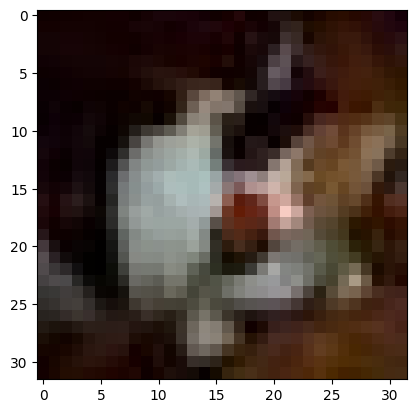

In [3]:
image = X[3]
label = Y[3]

print("\t Label Image==> ",label)
img = tf.reshape(image, (32,32,3)) # 32x32x3 channels
plt.imshow(img);

In [4]:

tf.get_logger().setLevel(logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "cat", "dog" ]
classes = len(classes_values)

Y = tf.keras.utils.to_categorical(Y - 1, classes)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

input_length = X_train[0].shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

callbacks = []


In [7]:
Dropout?

Init signature: Dropout(rate, noise_shape=None, seed=None, **kwargs)
Docstring:     
Applies dropout to the input.

The `Dropout` layer randomly sets input units to 0 with a frequency of
`rate` at each step during training time, which helps prevent overfitting.
Inputs not set to 0 are scaled up by `1 / (1 - rate)` such that the sum over
all inputs is unchanged.

Note that the `Dropout` layer only applies when `training` is set to `True`
in `call()`, such that no values are dropped during inference.
When using `model.fit`, `training` will be appropriately set to `True`
automatically. In other contexts, you can set the argument explicitly
to `True` when calling the layer.

(This is in contrast to setting `trainable=False` for a `Dropout` layer.
`trainable` does not affect the layer's behavior, as `Dropout` does
not have any variables/weights that can be frozen during training.)

Args:
    rate: Float between 0 and 1. Fraction of the input units to drop.
    noise_shape: 1D integer tensor

In [5]:

# model architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu',
    activity_regularizer=tf.keras.regularizers.l1(0.00001)))
model.add(Dense(classes, activation='softmax', name='y_pred'))

# this controls the learning rate
opt = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)
# This is only required for some input types, e.g. images
SPECIFIC_INPUT_SHAPE = (32, 32, 3)
train_dataset = train_dataset.map(get_reshape_function(SPECIFIC_INPUT_SHAPE), tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.map(get_reshape_function(SPECIFIC_INPUT_SHAPE), tf.data.experimental.AUTOTUNE)
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

# train the neural network
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset, verbose=2, callbacks=callbacks)


Epoch 1/10
250/250 - 2s - 9ms/step - accuracy: 0.5827 - loss: 0.6722 - val_accuracy: 0.6391 - val_loss: 0.6471
Epoch 2/10
250/250 - 2s - 8ms/step - accuracy: 0.6601 - loss: 0.6204 - val_accuracy: 0.6867 - val_loss: 0.5898
Epoch 3/10
250/250 - 2s - 8ms/step - accuracy: 0.6914 - loss: 0.5828 - val_accuracy: 0.7027 - val_loss: 0.5668
Epoch 4/10
250/250 - 2s - 8ms/step - accuracy: 0.7196 - loss: 0.5477 - val_accuracy: 0.7232 - val_loss: 0.5454
Epoch 5/10
250/250 - 2s - 9ms/step - accuracy: 0.7399 - loss: 0.5182 - val_accuracy: 0.7212 - val_loss: 0.5391
Epoch 6/10
250/250 - 2s - 9ms/step - accuracy: 0.7588 - loss: 0.4938 - val_accuracy: 0.7277 - val_loss: 0.5278
Epoch 7/10
250/250 - 2s - 9ms/step - accuracy: 0.7777 - loss: 0.4674 - val_accuracy: 0.7302 - val_loss: 0.5297
Epoch 8/10
250/250 - 2s - 9ms/step - accuracy: 0.7962 - loss: 0.4411 - val_accuracy: 0.7337 - val_loss: 0.5311
Epoch 9/10
250/250 - 2s - 9ms/step - accuracy: 0.8085 - loss: 0.4156 - val_accuracy: 0.7322 - val_loss: 0.5516
E

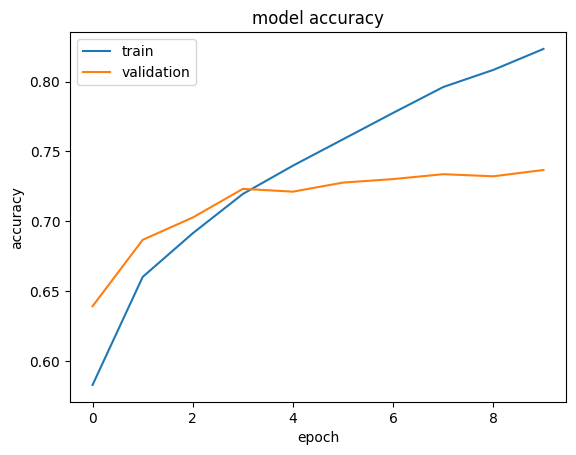

In [6]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.summary()

In [ ]:
# Save the model to disk
model.export('saved_model.zip')